# This note book will illustrate the Iris regridding algorithms used. For a small sampling combined land-sea area, the temperature phenomena are regridded from APS3 grids to APS2 grids for testing.

## The idea to be tested:
# How about Iris Regrid algorithm by applying coastline correction?

In [1]:
import iris
import sys

In [3]:
sys.path.append('/data/hwang/mds-gfe/mds-gfe-regridder')

### This is loading metadata from a sample testing area retrieving from APS3 UM files.

In [4]:
from mds_gfe_regrid.tests.model_tools.mds_regrid_test import *

In [5]:
topo_aps2 = empty_3d_cube_aps2(
    surface_alt_aps2_data, 'surface_altitude', 'm', 'm01s00i033')
topo_aps3 = empty_3d_cube_aps3(
    surface_alt_aps3_data, 'surface_altitude', 'm', 'm01s00i033')
lsm_aps2 = empty_3d_cube_aps2(
    lsm_aps2_data, 'land_area_fraction', '1', )
lsm_aps3 = empty_3d_cube_aps3(
    lsm_aps3_data, 'land_area_fraction', '1')
t_scn_aps3 = empty_3d_cube_aps3(
    t_scn_aps3_data, 'air_temperature', 'K')
dpt_scn_aps3 = empty_3d_cube_aps3(
    dpt_scn_aps3_data, 'dew_point_temperature', 'K', 'm01s03i250')
sfc_prs_aps3 = empty_3d_cube_aps3(
    sfc_prs_aps3_data, 'air_pressure_at_sea_level', 'Pa')

In [6]:
print(lsm_aps3.data)

[[1 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]]


In [7]:
print(lsm_aps2.data)

[[ 1.  0.  0.]
 [ 1.  1.  0.]
 [ 1.  1.  0.]]


In [8]:
print(topo_aps3.data)

[[  30.79901695   24.64077759    0.            0.            0.            0.        ]
 [  40.51713181   57.62937927   44.1620636     0.            0.            0.        ]
 [  61.04179001   77.5438385    68.0868454    27.50967216    0.            0.        ]
 [ 197.31484985  109.88461304   81.08721161   47.29803085    0.            0.        ]
 [ 500.52633667  204.61886597   96.57264709   57.00541687    0.            0.        ]
 [ 801.8571167   337.81097412  131.99372864   66.28527832    0.            0.        ]]


In [12]:
from mds_gfe_regrid.model_tools.iris_tools import *

In [13]:
def show_difference(cube_a, cube_b, accuracy=None, entropy=None):
    import numpy as np
    from numpy.testing import assert_array_less
    
    result = cube_a.data.flatten()
    expected = cube_b.data.flatten()
    
    if accuracy is None:
        accuracy = np.repeat(0.0001, len(result))
    if entropy is None:
        entropy = 0.02
    # Now assert the data is as expected.
    delta = np.abs(result - expected)
    msg = ('\nEntropy: {}\nExpected entropy: {}\n'
           'Index  -/x   Delta     Target   Expected value   Actual Value'
           ''.format(delta.sum(), entropy))
    template = '\n{0:3}     {1:2}  {2:6f}  {3:6f}    {4:6f}      {5:6f}'

    for i, (r_del, t_del, r, t) in enumerate(zip(delta, accuracy,
                                                 result, expected)):
        msg += template.format(i, '-' if r_del < t_del else 'x',
                               r_del, t_del,
                               t, r)
    # Ensure each accuracy component falls below the target.
    assert_array_less(delta, accuracy, msg)
    # Ensure that our entropy is close to the expected one.
    # If this fails because the result is now smaller than expected, good!
    # It means we can tighten the expected entropy *AND* the target delta.
    if np.abs(entropy - delta.sum()) > 0.001:
        print(msg)

## 1. Idea how Iris regrid intergrates with coastline correction: 
### starting with ideas from GFE coastline correction

In [14]:
def plot_two_cubes_in_same_scale(origin_cube, derived_cube, label_origin='Origin_UM', label_derived='Regridded_Data'):
    import matplotlib.pyplot as plt
    import iris.quickplot as qplt
    
    fig = plt.figure(figsize=(18, 12))

    fig.add_subplot(221)
    cm = qplt.pcolormesh(origin_cube)    
    plt.gca().coastlines()

    fig.add_subplot(222)
    qplt.pcolormesh(derived_cube, cmap=cm.cmap, norm=cm.norm)
    plt.gca().coastlines()

    print("             {}                                           {}".format(label_origin, label_derived))

    plt.show()

In [67]:
import numpy as np
def land_classify(land_grid, land_lats, land_lons, classify_latlons):
    """
    Classify surface types of a grid based on a binary True/False land mask.
    :param land_grid: numpy ndarray of bool, True where surface type is land (I x J)
    :param land_lats: numpy ndarray of land mask latitudes (I)
    :param land_lons: numpy ndarray of land mask longitudes (J)
    :param classify_latlons: numpy ndarray of latitude and longitude points to classify (N x 2)
    :return: numpy ndarray of classifications (N)
    """
    is_land = np.bool_(find_maskpts(classify_latlons, land_grid, land_lats, land_lons))
    return is_land

In [77]:
from scipy.interpolate import RegularGridInterpolator
def find_maskpts(sample_latlons, mask, mask_lats, mask_lons):
    """
    Nearest neighbour sample at points in a (land mask) grid.
    :param sample_latlons: numpy ndarray of latitudes and longitudes (N x 2)
    :param mask: numpy ndarray land mask (I x J)
    :param mask_lats: numpy ndarray of land mask latitudes (I)
    :param mask_lons: numpy ndarray of land mask longitudes (J)
    :return: numpy ndarray of point samples
    """
    mask_rg_interp = RegularGridInterpolator(
                        (mask_lats, mask_lons), mask, method='linear',
                        bounds_error=False, fill_value=0.0)
    samples = mask_rg_interp(sample_latlons)
    return samples

In [69]:
mask_lats = cube_land_aps3.coord('latitude').points
mask_lons = cube_land_aps3.coord('longitude').points

In [78]:
samples = find_maskpts(tgrid, cube_land_aps3.data, mask_lats, mask_lons)

In [74]:
print(tgrid)

[[[  6.328125  81.211053]
  [  6.328125  81.562616]
  [  6.328125  81.914179]]

 [[  6.5625    81.211053]
  [  6.5625    81.562616]
  [  6.5625    81.914179]]

 [[  6.796875  81.211053]
  [  6.796875  81.562616]
  [  6.796875  81.914179]]]


In [89]:
print((300.859375 + 300.4375 +300.53125)/3)

300.609375


In [90]:
print((300.859375 + 300.4375 +300.53125 +300.828125)/4)

300.6640625


In [79]:
print(samples)

[[ 300.88344903  300.66382534  300.70716069]
 [ 300.95641012  300.08969424  300.68359893]
 [ 297.48944652  299.26620242  300.67580714]]


In [72]:
print(output_data)

[[ 300.88344903  300.66382534  300.70716069]
 [ 300.95641012  300.08969424  300.68359893]
 [ 297.48944652  299.26620242  300.67580714]]


In [80]:
land_samples = find_maskpts(land_tgrid, cube_land_aps3.data, mask_lats, mask_lons)

In [81]:
print(land_samples)

[[    300.88344903  181824.73315112  182765.56538432]
 [    300.95641012     300.08969424  188528.55177533]
 [    297.48944652     299.26620242  194408.82833643]]


In [83]:
mask_lats_sea = cube_sea_aps3.coord('latitude').points
mask_lons_sea = cube_sea_aps3.coord('longitude').points

In [84]:
print(mask_lats_sea)

[ 6.26953125  6.38671875  6.50390625  6.62109375  6.73828125  6.85546875]


In [85]:
print(cube_sea_aps3.data)

[[-- -- 300.859375 300.4375 300.640625 300.8125]
 [-- -- -- 300.53125 300.578125 300.796875]
 [-- -- -- -- 300.640625 300.71875]
 [-- -- -- -- 300.71875 300.65625]
 [-- -- -- -- 300.71875 300.65625]
 [-- -- -- -- 300.59375 300.734375]]


In [86]:
print(sea_tgrid)

[[[-- --]
  [6.328125 81.562616]
  [6.328125 81.914179]]

 [[-- --]
  [-- --]
  [6.5625 81.914179]]

 [[-- --]
  [-- --]
  [6.796875 81.914179]]]


In [103]:
print(sea_aps3_indx)

[[ True  True False False False False]
 [ True  True  True False False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]]


In [108]:
sea_samples = find_maskpts(sea_tgrid, t_scn_aps3.data[land_aps3_indx], mask_lats, mask_lons)

ValueError: There are 2 point arrays, but values has 1 dimensions

In [105]:
print(sea_samples)

[ 300.859375  300.4375    300.640625  300.8125    300.53125   300.578125
  300.796875  300.640625  300.71875   300.71875   300.65625   300.71875
  300.65625   300.59375   300.734375]


In [10]:
print(t_scn_aps3.data)

[[ 300.0625    299.1875    300.859375  300.4375    300.640625  300.8125  ]
 [ 300.734375  303.546875  300.828125  300.53125   300.578125  300.796875]
 [ 302.0625    301.078125  300.703125  299.90625   300.640625  300.71875 ]
 [ 300.796875  299.890625  299.703125  300.046875  300.71875   300.65625 ]
 [ 297.078125  298.875     299.09375   300.078125  300.71875   300.65625 ]
 [ 296.125     297.875     298.5625    299.328125  300.59375   300.734375]]


In [ ]:
try:
    from sklearn.neighbors.kd_tree import KDTree
except ImportError as _:
    from scipy.spatial.ckdtree import cKDTree as KDTree

In [ ]:
distances, indexes = sampler.nearest_input_pts(in_latlons, out_latlons, k=2)

## 2. Start to use iris intermal function/method to do coastline correction

In [15]:
from iris.analysis._scipy_interpolate import _RegularGridInterpolator

In [16]:
lon_aps2 = topo_aps2.coord('longitude').points
lat_aps2 = topo_aps2.coord('latitude').points
lon_aps3 = topo_aps3.coord('longitude').points
lat_aps3 = topo_aps3.coord('latitude').points

In [322]:
print(lon_aps2)

[ 81.211053  81.562616  81.914179]


In [17]:
interpolator_linear = _RegularGridInterpolator([lat_aps3, lon_aps3], t_scn_aps3.data,
                                             method='linear',
                                             bounds_error=False,
                                             fill_value=None)

In [18]:
interpolator_nearest = _RegularGridInterpolator([lat_aps3, lon_aps3], t_scn_aps3.data,
                                             method='nearest',
                                             bounds_error=False,
                                             fill_value=None)

In [19]:
xv, yv = np.meshgrid(lon_aps2, lat_aps2)

In [20]:
tgrid = np.dstack((yv, xv))

In [21]:
print(tgrid)

[[[  6.328125  81.211053]
  [  6.328125  81.562616]
  [  6.328125  81.914179]]

 [[  6.5625    81.211053]
  [  6.5625    81.562616]
  [  6.5625    81.914179]]

 [[  6.796875  81.211053]
  [  6.796875  81.562616]
  [  6.796875  81.914179]]]


In [23]:
weights = interpolator_linear.compute_interp_weights(tgrid)

In [24]:
print(weights)

((3, 3, 2), 'linear', <9x36 sparse matrix of type '<type 'numpy.float64'>'
	with 36 stored elements in Compressed Sparse Row format>, None, array([False, False, False, False, False, False, False, False, False], dtype=bool))


In [26]:
output_data = interpolator_linear.interp_using_pre_computed_weights(weights)

In [27]:
print(output_data)

[[ 300.88344903  300.66382534  300.70716069]
 [ 300.95641012  300.08969424  300.68359893]
 [ 297.48944652  299.26620242  300.67580714]]


In [93]:
print(sea_tgrid)

[[[-- --]
  [6.328125 81.562616]
  [6.328125 81.914179]]

 [[-- --]
  [-- --]
  [6.5625 81.914179]]

 [[-- --]
  [-- --]
  [6.796875 81.914179]]]


In [98]:
sea_weights = sea_interpolator.compute_interp_weights(sea_tgrid)

In [99]:
output_data_sea = sea_interpolator.interp_using_pre_computed_weights(sea_weights)

In [100]:
print(output_data_sea)

[[ 182497.37520204     300.66382534     300.70716069]
 [ 186552.88301578  187330.1335001      300.68359893]
 [ 191003.20853386  192742.34635685     300.67580714]]


### 2.1 Now Using index land sea to check the difference

In [28]:
land_aps3_indx, sea_aps3_indx = get_land_sea_index(lsm_aps3)
land_aps2_indx, sea_aps2_indx = get_land_sea_index(lsm_aps2)


In [34]:
# Mask the APS3 sea points
cube_land_aps3 = transform_cube_by_masked_index(t_scn_aps3, land_aps3_indx)
# Mask the APS3 land points
cube_sea_aps3 = transform_cube_by_masked_index(t_scn_aps3, sea_aps3_indx)


In [35]:
print(cube_land_aps3.data)

[[300.0625 299.1875 -- -- -- --]
 [300.734375 303.546875 300.828125 -- -- --]
 [302.0625 301.078125 300.703125 299.90625 -- --]
 [300.796875 299.890625 299.703125 300.046875 -- --]
 [297.078125 298.875 299.09375 300.078125 -- --]
 [296.125 297.875 298.5625 299.328125 -- --]]


In [36]:
# Mask the APS2 sea points
cube_land_aps2 = transform_cube_by_masked_index(topo_aps2, land_aps2_indx)
# Mask the APS2 land points
cube_sea_aps2 = transform_cube_by_masked_index(topo_aps2, sea_aps2_indx)

In [37]:
type(tgrid), tgrid.shape

(numpy.ndarray, (3, 3, 2))

In [38]:
print(land_aps2_indx), land_aps2_indx.shape

[[False  True  True]
 [False False  True]
 [False False  True]] (3, 3)


In [39]:
rowmask = land_aps2_indx
xmask=np.stack((rowmask,rowmask),-1)  # column stack

In [40]:
land_tgrid = np.ma.masked_array(tgrid, mask = xmask)

In [41]:
print(land_tgrid)

[[[6.328125 81.211053]
  [-- --]
  [-- --]]

 [[6.5625 81.211053]
  [6.5625 81.562616]
  [-- --]]

 [[6.796875 81.211053]
  [6.796875 81.562616]
  [-- --]]]


In [43]:
land_weights = interpolator_linear.compute_interp_weights(land_tgrid)

In [44]:
print(land_weights)

((3, 3, 2), 'linear', <9x36 sparse matrix of type '<type 'numpy.float64'>'
	with 36 stored elements in Compressed Sparse Row format>, None, array([False, False, False, False, False, False, False, False, False], dtype=bool))


In [45]:
rowmask = land_aps3_indx
mask_aps3 = np.stack((rowmask,rowmask),-1)  # column stack

In [46]:
xv, yv = np.meshgrid(lon_aps3, lat_aps3)
tgrid_aps3 = np.dstack((yv, xv))

In [47]:
land_tgrid_aps3 = np.ma.masked_array(tgrid_aps3, mask = mask_aps3)

In [48]:
print(land_tgrid_aps3)

[[[6.26953125 81.12304688]
  [6.26953125 81.29882812]
  [-- --]
  [-- --]
  [-- --]
  [-- --]]

 [[6.38671875 81.12304688]
  [6.38671875 81.29882812]
  [6.38671875 81.47460938]
  [-- --]
  [-- --]
  [-- --]]

 [[6.50390625 81.12304688]
  [6.50390625 81.29882812]
  [6.50390625 81.47460938]
  [6.50390625 81.65039062]
  [-- --]
  [-- --]]

 [[6.62109375 81.12304688]
  [6.62109375 81.29882812]
  [6.62109375 81.47460938]
  [6.62109375 81.65039062]
  [-- --]
  [-- --]]

 [[6.73828125 81.12304688]
  [6.73828125 81.29882812]
  [6.73828125 81.47460938]
  [6.73828125 81.65039062]
  [-- --]
  [-- --]]

 [[6.85546875 81.12304688]
  [6.85546875 81.29882812]
  [6.85546875 81.47460938]
  [6.85546875 81.65039062]
  [-- --]
  [-- --]]]


In [49]:
land_interpolator = _RegularGridInterpolator((lat_aps3, lon_aps3), cube_land_aps3.data,
                                             method='linear',
                                             bounds_error=False,
                                             fill_value=None)

In [97]:
sea_interpolator = _RegularGridInterpolator((lat_aps3, lon_aps3), cube_sea_aps3.data,
                                             method='linear',
                                             bounds_error=True,
                                             fill_value=np.nan)

In [126]:
print(cube_sea_aps3.data)

[[-- -- 300.859375 300.4375 300.640625 300.8125]
 [-- -- -- 300.53125 300.578125 300.796875]
 [-- -- -- -- 300.640625 300.71875]
 [-- -- -- -- 300.71875 300.65625]
 [-- -- -- -- 300.71875 300.65625]
 [-- -- -- -- 300.59375 300.734375]]


In [56]:
land_weights_tgt = land_interpolator.compute_interp_weights(land_tgrid)

In [57]:
print(land_weights_tgt)

((3, 3, 2), 'linear', <9x36 sparse matrix of type '<type 'numpy.float64'>'
	with 36 stored elements in Compressed Sparse Row format>, None, array([False, False, False, False, False, False, False, False, False], dtype=bool))


In [58]:
land_output_data = land_interpolator.interp_using_pre_computed_weights(land_weights_tgt)

In [59]:
print(land_output_data)

[[    300.88344903  181824.73315112  182765.56538432]
 [    300.95641012     300.08969424  188528.55177533]
 [    297.48944652     299.26620242  194408.82833643]]


In [60]:
# Do the sea points
rowmask = sea_aps2_indx
sea_mask=np.stack((rowmask,rowmask),-1)  # column stack

In [61]:
print(sea_mask)

[[[ True  True]
  [False False]
  [False False]]

 [[ True  True]
  [ True  True]
  [False False]]

 [[ True  True]
  [ True  True]
  [False False]]]


In [62]:
sea_tgrid = np.ma.masked_array(tgrid, mask = sea_mask)

In [63]:
print(sea_tgrid)

[[[-- --]
  [6.328125 81.562616]
  [6.328125 81.914179]]

 [[-- --]
  [-- --]
  [6.5625 81.914179]]

 [[-- --]
  [-- --]
  [6.796875 81.914179]]]


In [64]:
sea_weights = sea_interpolator.compute_interp_weights(sea_tgrid)

In [122]:
print(sea_weights)

((3, 3, 2), 'linear', <9x36 sparse matrix of type '<type 'numpy.float64'>'
	with 36 stored elements in Compressed Sparse Row format>, None, array([False, False, False, False, False, False, False, False, False], dtype=bool))


In [65]:
sea_output_data = sea_interpolator.interp_using_pre_computed_weights(sea_weights)

In [66]:
print(sea_output_data)

[[ 182497.37520204     300.66382534     300.70716069]
 [ 186552.88301578  187330.1335001      300.68359893]
 [ 191003.20853386  192742.34635685     300.67580714]]


In [124]:
coords = np.array([[[50.7, -3.5],
                                [50.6, -3.5]],
                               [[50.7, -3.1],
                                [50.6, -3.1]]])

In [125]:
test = sea_interpolator.compute_interp_weights(coords)

ValueError: One of the requested xi is out of bounds in dimension 0

In [ ]:
type(sea_output_data)

In [ ]:
sea_output_data = np.ma.masked_array(sea_output_data, mask=sea_aps2_indx)

In [ ]:
land_weights = land_interpolator.compute_interp_weights(land_tgrid)

In [ ]:
land_output_data = land_interpolator.interp_using_pre_computed_weights(land_weights)

In [ ]:
print(land_output_data)

In [ ]:
combined_data = np.where(land_aps2_indx, sea_output_data, land_output_data)

In [ ]:
print(combined_data)

In [109]:
def show_data_difference(datum_a, datum_b, accuracy=None, entropy=None):
    import numpy as np
    from numpy.testing import assert_array_less
    
    result = datum_a.flatten()
    expected = datum_b.flatten()
    
    if accuracy is None:
        accuracy = np.repeat(0.0001, len(result))
    if entropy is None:
        entropy = 0.02
    # Now assert the data is as expected.
    delta = np.abs(result - expected)
    msg = ('\nEntropy: {}\nExpected entropy: {}\n'
           'Index  -/x   Delta     Target   Expected value   Actual Value'
           ''.format(delta.sum(), entropy))
    template = '\n{0:3}     {1:2}  {2:6f}  {3:6f}    {4:6f}      {5:6f}'

    for i, (r_del, t_del, r, t) in enumerate(zip(delta, accuracy,
                                                 result, expected)):
        msg += template.format(i, '-' if r_del < t_del else 'x',
                               r_del, t_del,
                               t, r)
    # Ensure each accuracy component falls below the target.
    assert_array_less(delta, accuracy, msg)
    # Ensure that our entropy is close to the expected one.
    # If this fails because the result is now smaller than expected, good!
    # It means we can tighten the expected entropy *AND* the target delta.
    if np.abs(entropy - delta.sum()) > 0.001:
        print(msg)

In [ ]:
show_data_difference(combined_data, drv_t_scn_iris.data)

## 3. Now pull everything together

In [ ]:
%reload_ext autoreload

In [118]:
regridder = MdsRegridder(topo_aps3, topo_aps2, lsm_aps3, lsm_aps2)

In [119]:
t_scn_by_iris_cc_list = regridder._regrid_iris_coastline_correction(t_scn_aps3)

In [120]:
[t_scn_by_iris_cc]= t_scn_by_iris_cc_list.extract('air_temperature')
print(t_scn_by_iris_cc)

air_temperature / (K)               (latitude: 3; longitude: 3)
     Dimension coordinates:
          latitude                           x             -
          longitude                          -             x
     Scalar coordinates:
          time: 1970-01-01 00:00:00


In [121]:
print(t_scn_by_iris_cc.data)

[[ 300.88344903  300.66382534  300.70716069]
 [ 300.95641012  300.08969424  300.68359893]
 [ 297.48944652  299.26620242  300.67580714]]


In [116]:
print(output_data_sea)

[[ 182497.37520204     300.66382534     300.70716069]
 [ 186552.88301578  187330.1335001      300.68359893]
 [ 191003.20853386  192742.34635685     300.67580714]]


## 4. Validate somehow: Need to find the nearest coastline observation points

In [132]:
def get_grid_vector(lat, lon):
    """
    Convert input lat, lon (nparray) into grid_mesh for scipy interpolate;
    First step to prepare for scipy interpolation.
    """
    import numpy as np
    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lat_vec = np.ravel(lat_mesh)
    lon_vec = np.ravel(lon_mesh)
    return lat_vec, lon_vec

def get_grid_points(lat, lon):
    """
    Convert input lat, lon (nparray) into grid_points for scipy interpolate.
    """
    lat_vec, lon_vec = get_grid_vector(lat, lon)
    grid_points = np.vstack((lat_vec, lon_vec)).T
    return grid_points

In [127]:
def interpolate_cube_by_scipy(src_cube, src_grid_cube, tgt_grid_cube, method='linear'):
    """
    Use Scipy to interpolate input cube (source data) to target grid.
    ------
    Input:
        src_cube: the metadata cube on src_grids
        src_grid_cube: a cube with source grids
        tgt_grid_cube: a cube with target grids
        method: the interpolate method used by scipy RegularGridInterpolator
                only available "linear" & "nearest"
    Output:
        tgt_data: the interpolated data on target grids.
    """
    import scipy.interpolate as interpolator

    # Need prepare grid_points and vestor for scipy interpolator
    src_data = src_cube.data
    src_data_vec = np.ravel(src_data)
    
    # lat_src or lat_tgt: the latitude 1d np.array from source or target grids
    # lon_src or lon_tgt: the longitude 1d np.array from source or target grids
    lat_src = src_grid_cube.coord('latitude').points
    lon_src = src_grid_cube.coord('longitude').points
    
    lat_tgt = tgt_grid_cube.coord('latitude').points
    lon_tgt = tgt_grid_cube.coord('longitude').points
    
    grid_points_src = get_grid_points(lat_src, lon_src)
    lat_tgt_vec, lon_tgt_vec = get_grid_vector(lat_tgt, lon_tgt)
    
    # Define the interpolator
    if method == 'linear':
        scipy_interp = interpolator.LinearNDInterpolator(grid_points_src, src_data_vec)
    elif method == 'nearest':
        scipy_interp = interpolator.NearestNDInterpolator(grid_points_src, src_data_vec)
    else:
        raise ValueError("Only linear and nearest interpolations are available!")
    # Derive
    tgt_data = scipy_interp(lat_tgt_vec, lon_tgt_vec)
    # Need reshape back to 2d
    tgt_data = tgt_data.reshape(len(lat_tgt), len(lon_tgt))
    
    tgt_cube = create_derive_cube(src_cube, tgt_grid_cube)
    tgt_cube.data = tgt_data
    return tgt_cube

In [253]:
def interpolate_by_scipy(src_data, lat_src, lon_src, lat_tgt, lon_tgt, method='linear'):
    """
    Use Scipy to interpolate input source data to target grid.
    ------
    Input:
        src_data: the metadata on src_grids
        lat_src or lat_tgt: the latitude 1d np.array from source or target grids
        lon_src or lon_tgt: the longitude 1d np.array from source or target grids
        method: the interpolate method used by scipy RegularGridInterpolator
                only available "linear" & "nearest"
    Output:
        tgt_data: the interpolated data on target grids.
    """
    import scipy.interpolate as interpolator

    # Need prepare grid_points and vestor for scipy interpolator
    src_data_vec = np.ravel(src_data)
    grid_points_src = get_grid_points(lat_src, lon_src)
    lat_tgt_vec, lon_tgt_vec = get_grid_vector(lat_tgt, lon_tgt)
    
    # Define the interpolator
    if method == 'linear':
        scipy_interp = interpolator.LinearNDInterpolator(grid_points_src, src_data_vec)
    elif method == 'nearest':
        scipy_interp = interpolator.NearestNDInterpolator(grid_points_src, src_data_vec)
    else:
        raise ValueError("Only linear and nearest interpolations are available!")
    # Derive
    tgt_data = scipy_interp(lat_tgt_vec, lon_tgt_vec)
    # Need reshape back to 2d
    tgt_data = tgt_data.reshape(len(lat_tgt), len(lon_tgt))
    return tgt_data

In [130]:
print(cube_sea_aps2.data)

[[-- 0.0 0.0]
 [-- -- 0.0]
 [-- -- 0.0]]


In [133]:
test_sea = interpolate_cube_by_scipy(cube_sea_aps3, cube_sea_aps3, cube_sea_aps2)

In [134]:
print(test_sea.data)

[[ 301.80512897  300.69529197  300.69530223]
 [ 300.9757273   300.37434009  300.64848906]
 [ 297.47593081  299.21058541  300.62505178]]


In [150]:
test_land = interpolate_cube_by_scipy(cube_land_aps3, lsm_aps3, lsm_aps2)

In [151]:
print(test_land.data)

[[ 301.80512897  300.69529197  300.69530223]
 [ 300.9757273   300.37434009  300.64848906]
 [ 297.47593081  299.21058541  300.62505178]]


In [138]:
print(output_data)

[[ 300.88344903  300.66382534  300.70716069]
 [ 300.95641012  300.08969424  300.68359893]
 [ 297.48944652  299.26620242  300.67580714]]


In [141]:
print(sea_aps3_indx)

[[ True  True False False False False]
 [ True  True  True False False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]]


In [147]:
# This is producing the sea data due to indx setup
t_scn_aps3.data[land_aps3_indx]

array([ 300.859375,  300.4375  ,  300.640625,  300.8125  ,  300.53125 ,
        300.578125,  300.796875,  300.640625,  300.71875 ,  300.71875 ,
        300.65625 ,  300.71875 ,  300.65625 ,  300.59375 ,  300.734375])

In [143]:
t_scn_aps3_data

array([[ 300.0625  ,  299.1875  ,  300.859375,  300.4375  ,  300.640625,
         300.8125  ],
       [ 300.734375,  303.546875,  300.828125,  300.53125 ,  300.578125,
         300.796875],
       [ 302.0625  ,  301.078125,  300.703125,  299.90625 ,  300.640625,
         300.71875 ],
       [ 300.796875,  299.890625,  299.703125,  300.046875,  300.71875 ,
         300.65625 ],
       [ 297.078125,  298.875   ,  299.09375 ,  300.078125,  300.71875 ,
         300.65625 ],
       [ 296.125   ,  297.875   ,  298.5625  ,  299.328125,  300.59375 ,
         300.734375]])

In [148]:
cube_sea = t_scn_aps3.copy()
cube_sea.data = t_scn_aps3.data[land_aps3_indx]

ValueError: Require cube data with shape (6, 6), got (15,).

In [234]:
def produce_land_sea_index(lsm_cube):
    """
    Return the land_indx and sea_indx from a given lsm_cube.
    Note: this method is not for mask
    """
    # Need to be true for the sea points
    sea_index = (lsm_cube.data == 0)
    # The land points 
    land_index = (lsm_cube.data != 0)
    return land_index, sea_index

In [235]:
land_indx_src, sea_indx_src = produce_land_sea_index(lsm_aps3)

In [237]:
print(sea_indx_src)

[[False False  True  True  True  True]
 [False False False  True  True  True]
 [False False False False  True  True]
 [False False False False  True  True]
 [False False False False  True  True]
 [False False False False  True  True]]


In [238]:
src_sea_data = t_scn_aps3.data[sea_indx_src]

In [239]:
print(src_sea_data)

[ 300.859375  300.4375    300.640625  300.8125    300.53125   300.578125
  300.796875  300.640625  300.71875   300.71875   300.65625   300.71875
  300.65625   300.59375   300.734375]


In [240]:
src_grid_cube = topo_aps3
lat_src = src_grid_cube.coord('latitude').points
lon_src = src_grid_cube.coord('longitude').points


In [242]:
grid_points_src = get_grid_points(lat_src, lon_src)

In [243]:
src_cube = t_scn_aps3
src_data = src_cube.data
src_data_vec = np.ravel(src_data)

In [247]:
src_data_vec

array([ 300.0625  ,  299.1875  ,  300.859375,  300.4375  ,  300.640625,
        300.8125  ,  300.734375,  303.546875,  300.828125,  300.53125 ,
        300.578125,  300.796875,  302.0625  ,  301.078125,  300.703125,
        299.90625 ,  300.640625,  300.71875 ,  300.796875,  299.890625,
        299.703125,  300.046875,  300.71875 ,  300.65625 ,  297.078125,
        298.875   ,  299.09375 ,  300.078125,  300.71875 ,  300.65625 ,
        296.125   ,  297.875   ,  298.5625  ,  299.328125,  300.59375 ,
        300.734375])

In [248]:
cube_land_aps3.data

masked_array(data =
 [[300.0625 299.1875 -- -- -- --]
 [300.734375 303.546875 300.828125 -- -- --]
 [302.0625 301.078125 300.703125 299.90625 -- --]
 [300.796875 299.890625 299.703125 300.046875 -- --]
 [297.078125 298.875 299.09375 300.078125 -- --]
 [296.125 297.875 298.5625 299.328125 -- --]],
             mask =
 [[False False  True  True  True  True]
 [False False False  True  True  True]
 [False False False False  True  True]
 [False False False False  True  True]
 [False False False False  True  True]
 [False False False False  True  True]],
       fill_value = 1e+20)

In [249]:
cube_src_land_data = np.where(lsm_aps3_data ==0, np.nan, t_scn_aps3_data)

In [250]:
print(cube_src_land_data)

[[ 300.0625    299.1875           nan         nan         nan         nan]
 [ 300.734375  303.546875  300.828125         nan         nan         nan]
 [ 302.0625    301.078125  300.703125  299.90625          nan         nan]
 [ 300.796875  299.890625  299.703125  300.046875         nan         nan]
 [ 297.078125  298.875     299.09375   300.078125         nan         nan]
 [ 296.125     297.875     298.5625    299.328125         nan         nan]]


In [251]:
src_sea_indx = np.where(np.in1d(src_data_vec, cube_src_land_data))

In [252]:
src_sea_indx

(array([ 0,  1,  6,  7,  8, 11, 12, 13, 14, 15, 18, 19, 20, 21, 24, 25, 26,
        27, 30, 31, 32, 33, 35]),)

In [159]:
print(tgrid_aps3)

[[[  6.26953125  81.12304688]
  [  6.26953125  81.29882812]
  [  6.26953125  81.47460938]
  [  6.26953125  81.65039062]
  [  6.26953125  81.82617188]
  [  6.26953125  82.00195312]]

 [[  6.38671875  81.12304688]
  [  6.38671875  81.29882812]
  [  6.38671875  81.47460938]
  [  6.38671875  81.65039062]
  [  6.38671875  81.82617188]
  [  6.38671875  82.00195312]]

 [[  6.50390625  81.12304688]
  [  6.50390625  81.29882812]
  [  6.50390625  81.47460938]
  [  6.50390625  81.65039062]
  [  6.50390625  81.82617188]
  [  6.50390625  82.00195312]]

 [[  6.62109375  81.12304688]
  [  6.62109375  81.29882812]
  [  6.62109375  81.47460938]
  [  6.62109375  81.65039062]
  [  6.62109375  81.82617188]
  [  6.62109375  82.00195312]]

 [[  6.73828125  81.12304688]
  [  6.73828125  81.29882812]
  [  6.73828125  81.47460938]
  [  6.73828125  81.65039062]
  [  6.73828125  81.82617188]
  [  6.73828125  82.00195312]]

 [[  6.85546875  81.12304688]
  [  6.85546875  81.29882812]
  [  6.85546875  81.47460938]


In [160]:
grid_points_src_sea = tgrid_aps3[sea_index_src]

In [161]:
print(grid_points_src_sea)

[[  6.26953125  81.47460938]
 [  6.26953125  81.65039062]
 [  6.26953125  81.82617188]
 [  6.26953125  82.00195312]
 [  6.38671875  81.65039062]
 [  6.38671875  81.82617188]
 [  6.38671875  82.00195312]
 [  6.50390625  81.82617188]
 [  6.50390625  82.00195312]
 [  6.62109375  81.82617188]
 [  6.62109375  82.00195312]
 [  6.73828125  81.82617188]
 [  6.73828125  82.00195312]
 [  6.85546875  81.82617188]
 [  6.85546875  82.00195312]]


In [165]:
grid_points_src_sea.shape

(15, 2)

In [166]:
np.ravel(grid_points_src_sea).shape

(30,)

In [167]:
import scipy.interpolate as interpolator
scipy_interp = interpolator.LinearNDInterpolator(grid_points_src_sea, src_data_vec_sea)

In [168]:
# Here the tgrid is tgrid_aps2 (or namely grid_tgt)
print(tgrid)

[[[  6.328125  81.211053]
  [  6.328125  81.562616]
  [  6.328125  81.914179]]

 [[  6.5625    81.211053]
  [  6.5625    81.562616]
  [  6.5625    81.914179]]

 [[  6.796875  81.211053]
  [  6.796875  81.562616]
  [  6.796875  81.914179]]]


In [170]:
land_index_tgt, sea_index_tgt = produce_land_sea_index(lsm_aps2)

In [171]:
grid_points_tgt_sea = tgrid[sea_index_tgt]

In [172]:
print(grid_points_tgt_sea)

[[  6.328125  81.562616]
 [  6.328125  81.914179]
 [  6.5625    81.914179]
 [  6.796875  81.914179]]


In [174]:
test_point = scipy_interp(6.328125, 81.562616)

In [175]:
print(test_point)

300.6950341


In [176]:
test_sea_results = scipy_interp(grid_points_tgt_sea)

In [177]:
print(test_sea_results)

[ 300.6950341   300.69545748  300.64848928  300.6250932 ]


In [178]:
print(output_data_sea)

[[ 182497.37520204     300.66382534     300.70716069]
 [ 186552.88301578  187330.1335001      300.68359893]
 [ 191003.20853386  192742.34635685     300.67580714]]


In [180]:
print(test_sea.data)

[[ 301.80512897  300.69529197  300.69530223]
 [ 300.9757273   300.37434009  300.64848906]
 [ 297.47593081  299.21058541  300.62505178]]


## Now new implementation for testing

In [192]:
input_cubes = iris.cube.CubeList()

In [193]:
input_cubes.append(t_scn_aps3)

In [275]:
def scipy_interpolate_cube_by_index(src_cube, lsm_index, tgt_grid_cube, method='linear'):
    """
    Use Scipy to interpolate input cube (source data) to target grid.
    ------
    Input:
        src_cube: the metadata cube on src_grids
        src_grid_cube: a cube with source grids
        tgt_grid_cube: a cube with target grids
        method: the interpolate method used by scipy RegularGridInterpolator
                only available "linear" & "nearest"
    Output:
        tgt_data: the interpolated data on target grids.
    """
    import scipy.interpolate as interpolator

    # Need prepare grid_points and vestor for scipy interpolator
    src_data = src_cube.data
    src_data_vec = np.ravel(src_data)
    
    # lat_src or lat_tgt: the latitude 1d np.array from source or target grids
    # lon_src or lon_tgt: the longitude 1d np.array from source or target grids
    lat_src = src_cube.coord('latitude').points
    lon_src = src_cube.coord('longitude').points
    
    lat_tgt = tgt_grid_cube.coord('latitude').points
    lon_tgt = tgt_grid_cube.coord('longitude').points
    
    grid_points_src = get_grid_points(lat_src, lon_src)
    lat_tgt_vec, lon_tgt_vec = get_grid_vector(lat_tgt, lon_tgt)
    
    # Define the interpolator
    if method == 'linear':
        scipy_interp = interpolator.LinearNDInterpolator(grid_points_src, src_data_vec)
    elif method == 'nearest':
        scipy_interp = interpolator.NearestNDInterpolator(grid_points_src, src_data_vec)
    else:
        raise ValueError("Only linear and nearest interpolations are available!")
    # Derive
    tgt_data = scipy_interp(lat_tgt_vec, lon_tgt_vec)
    # Need reshape back to 2d
    tgt_data = tgt_data.reshape(len(lat_tgt), len(lon_tgt))
    
    tgt_cube = create_derive_cube(src_cube, tgt_grid_cube)
    tgt_cube.data = tgt_data
    return tgt_cube

In [318]:
class MdsRegridder(object):
    """
    Regrid the cubes with a range of optional algorithms.
    """
    def __init__(self, src_topo, tgt_topo,
                 src_lsm=None, tgt_lsm=None):
        """
        src_topo: a cube of source topograph (required)
        tgt_topo: a cube of target topograph (required)
        src_lsm: a cube of source land binary mask (optional)
        tgt_lsm: a cube of target land binary mask (optional)
        """
        self.src_topo = src_topo
        self.tgt_topo = tgt_topo

        # calculate dz cube for height adjustment
        self.drv_tgt_topo = regrid_cube_by_scheme(
                                self.src_topo, self.tgt_topo, 'linear')
        self.dz = self.drv_tgt_topo - self.tgt_topo

        if src_lsm and tgt_lsm:
            # Providing both lsm are available
            self.src_lsm = src_lsm
            self.tgt_lsm = tgt_lsm
            self.src_lsm_land_indx, self.src_lsm_sea_indx = \
                get_land_sea_index(self.src_lsm)
            self.tgt_lsm_land_indx, self.tgt_lsm_sea_indx = \
                get_land_sea_index(self.tgt_lsm)
                
    def _regrid_iris_coastline_correction(
            self, input_cubes, algorithm='linear'):
        """
        Use iris.analysis._interpolate for coastline correction and
        then combine with Iris.regrid;
        For 'area-weighted', use '_regrid_iris_two_stage' for 'cc'.
         ------
        Args:
            input_cubes: the source input cubes
            algorithm: a string descrbing the regridding scheme used,
                       i.e. only "linear" and "nearest"
        Returns:
            The interpolated cube with coastline correction.
        """
        # kafka_log, full_log = getLoggers()
        # If the input is only a param_cube, turn it into CubeList
        if not isinstance(input_cubes, iris.cube.CubeList):
            input_cube_list = iris.cube.CubeList([])
            input_cube_list.append(input_cubes)
            input_cubes = input_cube_list

        regridded_cubes = iris.cube.CubeList([])

        if self.src_lsm is None or self.tgt_lsm is None:
            raise ValueError("Need land/sea mask to initialize MdsRegridder!")

        for cube in input_cubes:
         for cube in input_cubes:
            #full_log.info("Processing " + cube.name())
            # Masked the APS3 sea points
            cube_src_land = transform_cube_by_masked_index(
                cube, self.src_lsm_land_indx)
            # Masked the APS3 land points
            cube_src_sea = transform_cube_by_masked_index(
                cube, self.src_lsm_sea_indx)

            # interp with land/sea indexed data
            cube_tgt_land = interpolate_cube_by_scipy(
                cube_src_land, self.src_topo, self.tgt_topo)
            cube_tgt_sea = interpolate_cube_by_scipy(
                cube_src_sea, self.src_topo, self.tgt_topo)

            combined_data = np.where(self.tgt_lsm_land_indx,
                                     cube_tgt_sea.data,
                                     cube_tgt_land.data)

            drv_cube = cube_tgt_land.copy()
            drv_cube.data = combined_data

            regridded_cubes.append(drv_cube)

        return regridded_cubes
           
            
            
            # full_log.info("Processing " + cube.name())
            # Masked the APS3 sea points
            #cube_src_land = cube.copy()
            #cube_src_land.data = np.where(
            #    self.src_lsm.data == 0, np.nan, cube.data)
            # Masked the APS3 land points
            #cube_src_sea = cube.copy()
            #cube_src_sea.data = np.where(
            #    self.src_lsm.data != 0, np.nan, cube.data)

            # Get src/tgt lat, lon
            #lat_src, lon_src = get_cube_grid_points(self.src_lsm)
            #lat_tgt, lon_tgt = get_cube_grid_points(self.tgt_lsm)
            
            # interp with land/sea indexed data
            #cube_tgt_land_data = interpolate_by_scipy(
            #    cube_src_land_data, lat_src, lon_src, lat_tgt, lon_tgt, method=algorithm)
            #cube_tgt_sea_data = interpolate_by_scipy(
            #    cube_src_sea_data, lat_src, lon_src, lat_tgt, lon_tgt, method=algorithm)

            #cube_tgt_land = scipy_interpolate_cube_by_index(
            #    cube_src_land, self.src_lsm, self.tgt_topo, method=algorithm)
            #cube_tgt_sea_data = scipy_interpolate_cube_by_index(
            #    cube_src_sea, self.src_lsm, self.tgt_topo, method=algorithm)
            
            #import pdb;pdb.set_trace()
            #combined_data = np.where(self.tgt_lsm_land_indx,
            #                         cube_tgt_sea.data,
            #                         cube_tgt_land.data)

            #drv_cube = create_derive_cube(cube, self.tgt_topo)
            
            # Masked the APS3 sea points
            #cube_src_land = transform_cube_by_masked_index(
            #    cube, self.src_lsm_land_indx)
            # Masked the APS3 land points
            #cube_src_sea = transform_cube_by_masked_index(
            #    cube, self.src_lsm_sea_indx)

            # interp with land/sea indexed data
            #cube_tgt_land = interpolate_cube_by_scipy(
            #    cube_src_land, self.src_topo, self.tgt_topo)
            #cube_tgt_sea = interpolate_cube_by_scipy(
            #    cube_src_sea, self.src_topo, self.tgt_topo)

            #combined_data = np.where(self.tgt_lsm_land_indx,
            #                         cube_tgt_sea.data,
            #                         cube_tgt_land.data)

            #drv_cube = cube_tgt_land.copy()
            
            
            #drv_cube.data = combined_data

            #regridded_cubes.append(drv_cube)

        #return regridded_cubes

In [315]:
%reload_ext autoreload

In [279]:
regridder = MdsRegridder(topo_aps3, topo_aps2, lsm_aps3, lsm_aps2)

In [280]:
regridded_cubes = regridder._regrid_iris_coastline_correction(input_cubes)

In [281]:
print(regridded_cubes)

0: air_temperature / (K)               (latitude: 3; longitude: 3)


In [282]:
test_t = regridded_cubes[0]
print(test_t.data)

[[ 301.80512897  300.69529197  300.69530223]
 [ 300.9757273   300.37434009  300.64848906]
 [ 297.47593081  299.21058541  300.62505178]]


In [207]:
test_t = regridded_cubes[0]
print(test_t.data)

[[ 301.80512897  300.69529197  300.69530223]
 [ 300.9757273   300.37434009  300.64848906]
 [ 297.47593081  299.21058541  300.62505178]]


In [196]:
test_t = regridded_cubes[0]
print(test_t.data)

[[ 300.88344903  300.66382534  300.70716069]
 [ 300.95641012  300.08969424  300.68359893]
 [ 297.48944652  299.26620242  300.67580714]]


In [208]:
regridded_cubes = regridder._regrid_iris_coastline_correction(input_cubes)

> <ipython-input-202-3c50a3db7ca9>(70)_regrid_iris_coastline_correction()
-> combined_data = np.where(self.tgt_lsm_land_indx,
(Pdb) cube_src_sea.data
masked_array(data =
 [[-- -- 300.859375 300.4375 300.640625 300.8125]
 [-- -- -- 300.53125 300.578125 300.796875]
 [-- -- -- -- 300.640625 300.71875]
 [-- -- -- -- 300.71875 300.65625]
 [-- -- -- -- 300.71875 300.65625]
 [-- -- -- -- 300.59375 300.734375]],
             mask =
 [[ True  True False False False False]
 [ True  True  True False False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]
 [ True  True  True  True False False]],
       fill_value = 1e+20)

(Pdb) cube_src_land.data
masked_array(data =
 [[300.0625 299.1875 -- -- -- --]
 [300.734375 303.546875 300.828125 -- -- --]
 [302.0625 301.078125 300.703125 299.90625 -- --]
 [300.796875 299.890625 299.703125 300.046875 -- --]
 [297.078125 298.875 299.09375 300.078125 -- --]
 [296.125 297.875 298.5625 299.

### Validate from um aps3 inputs

In [283]:
um_files = ["/data/hwang/mds_data/incoming/APS3/umglaa_20170205T12_slv_003",
            "/data/hwang/mds_data/incoming/APS3/umglaa_20170205T12_cld_003",
            "/data/hwang/mds_data/incoming/APS3/umglaa_20170205T12_spec_003",]

In [284]:
cubes_aps = iris.load(um_files)

In [285]:
test_t_um_aps3 = get_screen_param_from_cube_list(cubes_aps, 'air_temperature')
print(test_t_um_aps3)

air_temperature / (K)               (latitude: 1536; longitude: 2048)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Scalar coordinates:
          forecast_period: 1.0 hours
          forecast_reference_time: 2017-02-05 12:00:00
          height: 1.5 m
          time: 2017-02-05 13:00:00
     Attributes:
          STASH: m01s03i236
          source: Data from Met Office Unified Model
          um_version: 10.6


In [288]:
file_2 = "/data/hwang/mds_data/incoming/qwxbjva_pa003_2016120100_utc_fc.um"
out_grids = iris.load(file_2)

In [289]:
topo_um_aps3 = get_topo_cube(cubes_aps)
lsm_um_aps3= get_lsm_cube(cubes_aps)

In [290]:
print(topo_um_aps3)
print(lsm_um_aps3)

surface_altitude / (m)              (latitude: 1536; longitude: 2048)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Scalar coordinates:
          forecast_period: 1.0 hours
          forecast_reference_time: 2017-02-05 12:00:00
          time: 2017-02-05 13:00:00
     Attributes:
          STASH: m01s00i033
          source: Data from Met Office Unified Model
          um_version: 10.6
land_binary_mask / (1)              (latitude: 1536; longitude: 2048)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Scalar coordinates:
          forecast_period: 1.0 hours
          forecast_reference_time: 2017-02-05 12:00:00
          time: 2017-02-05 13:00:00
     Attributes:
          STASH: m01s00i030
          source: Data from Met Office Unified Model
          um_versio

In [291]:
topo_um_aps2 = get_topo_cube(out_grids)
lsm_um_aps2= get_lsm_cube(out_grids)

In [292]:
print(topo_um_aps2)
print(lsm_um_aps2)

surface_altitude / (m)              (latitude: 769; longitude: 1024)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          forecast_period: 3.0 hours
          forecast_reference_time: 2016-12-01 00:00:00
          time: 2016-12-01 03:00:00
     Attributes:
          STASH: m01s00i033
          source: Data from Met Office Unified Model
          um_version: 8.2
land_binary_mask / (1)              (latitude: 769; longitude: 1024)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          forecast_period: 3.0 hours
          forecast_reference_time: 2016-12-01 00:00:00
          time: 2016-12-01 03:00:00
     Attributes:
          STASH: m01s00i030
          source: Data from Met Office Unified Model
          um_version: 8.2


In [319]:
mds_regridder = MdsRegridder(topo_um_aps3, topo_um_aps2, lsm_um_aps3, lsm_um_aps2)

In [320]:
%timeit
test_regridded_t = mds_regridder._regrid_iris_coastline_correction(test_t_um_aps3)
print(test_regridded_t)

0: air_temperature / (K)               (latitude: 769; longitude: 1024)


In [296]:
from mds_gfe_regrid.model_tools.mds_regrid import MdsRegridder

In [297]:
mds_regridder = MdsRegridder(topo_um_aps3, topo_um_aps2, lsm_um_aps3, lsm_um_aps2)

In [298]:
test_t_linear = mds_regridder._regrid(test_t_um_aps3)
print(test_t_linear)

2017-10-02 05:13:51,117  INFO Regridder Processing air_temperature


0: air_temperature / (K)               (latitude: 769; longitude: 1024)


In [302]:
test_t_linear[0].data - test_regridded_t[0].data

array([[        nan,         nan,         nan, ..., -0.30859375,
        -0.2109375 , -0.30078125],
       [-0.3203125 , -0.15625   , -0.30859375, ..., -0.640625  ,
        -0.734375  , -0.5625    ],
       [-0.71484375, -0.67578125, -0.80859375, ...,  0.6484375 ,
         0.6953125 ,  0.6796875 ],
       ..., 
       [ 0.1796875 ,  0.11328125, -0.140625  , ...,  0.6171875 ,
         0.8515625 ,  0.92578125],
       [ 0.1875    , -0.0625    , -0.0546875 , ...,  0.77734375,
         0.78515625,  0.875     ],
       [ 0.109375  ,  0.        ,  0.328125  , ..., -0.01953125,
        -0.0234375 ,         nan]])

In [304]:
np.isnan(test_t_linear[0].data)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [305]:
np.isnan(test_regridded_t[0].data)

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]], dtype=bool)

In [306]:
def plot_two_cubes_in_same_scale(origin_cube, derived_cube, label_origin='Origin_UM', label_derived='Regridded_Data'):
    import matplotlib.pyplot as plt
    import iris.quickplot as qplt
    
    fig = plt.figure(figsize=(18, 12))

    fig.add_subplot(221)
    cm = qplt.pcolormesh(origin_cube)    
    plt.gca().coastlines()

    fig.add_subplot(222)
    qplt.pcolormesh(derived_cube, cmap=cm.cmap, norm=cm.norm)
    plt.gca().coastlines()

    print("             {}                                           {}".format(label_origin, label_derived))

    plt.show()

/data/hwang/conda/miniconda3/envs/pre-proc-py2/lib/python2.7/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


             Coastline Correction                                           Linear


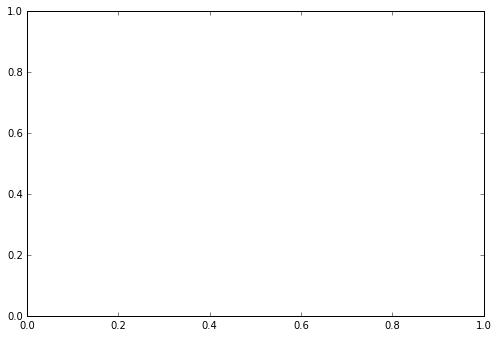

/data/hwang/conda/miniconda3/envs/pre-proc-py2/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


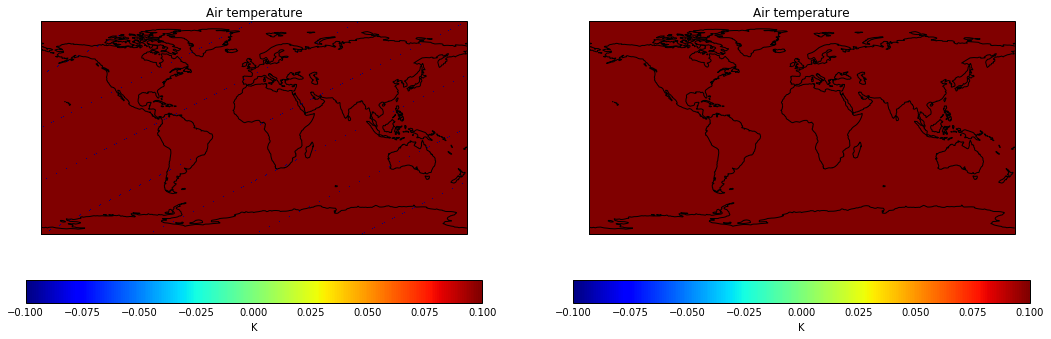

In [308]:
plot_two_cubes_in_same_scale(test_regridded_t[0], test_t_linear[0], 
                             label_origin='Coastline Correction', label_derived='Linear')

             Linear                                           Coastline Correction


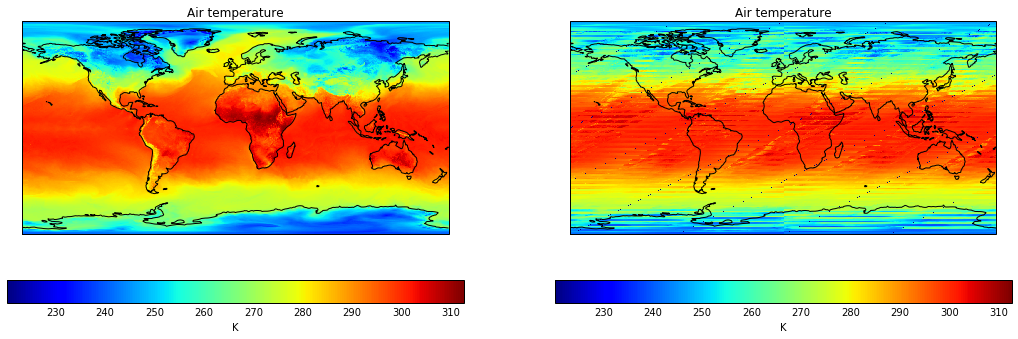

In [321]:
plot_two_cubes_in_same_scale(test_t_linear[0], test_regridded_t[0], 
                             label_origin='Linear', 
                             label_derived='Coastline Correction')